Here I will create a Neural Network and train using "back propogation" to recognise the hand written digits using MNIST Dataset.
Taken Some Ideas rather Code for last leg of this assignment from [Here
](https://colab.research.google.com/drive/1slcyr-RF40mi_oSqEcMWuvCnloBNxGSW). Also Uses ChatGPT for plotting the confusion matrix, Surprisingly it has given the accurate response. Also I would like to thank **Rohan (MA22M025)** for helping me in backpropagation part.

# Importing The Usefull Libraries

In [ ]:
#Importing the libraries that will be helpful during calculation
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

# Loading DataSet From Pytorch

In [ ]:
from torchvision import datasets
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()   # it converts PIL image into pytorch tensor and also normalise it
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()  # it converts PIL image into pytorch tensor and also normalise it
)

100%|██████████| 9912422/9912422 [00:00<00:00, 108961875.77it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23237232.65it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 30874101.67it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7153784.74it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Preproccesing The DATA

In [ ]:
VALID_RATIO = 0.9
# Spilliting the data into train and validation sets
n_train_examples = int(len(training_data) * VALID_RATIO)
n_valid_examples = len(training_data) - n_train_examples
train_data, valid_data = torch.utils.data.random_split(training_data,
                                           [n_train_examples, n_valid_examples])

In [ ]:
def Data(Train,Valid,Test,Batch_Size=64):
    train_iterator = torch.utils.data.DataLoader(Train,
                                    shuffle=True,
                                    batch_size=Batch_Size,
                                    drop_last=True)

    valid_iterator =torch.utils.data.DataLoader(Valid,
                                    batch_size=6000)

    test_iterator =torch.utils.data.DataLoader(Test,
                                    batch_size=10000)
    return train_iterator,valid_iterator,test_iterator

In [ ]:
train_iterator,valid_iterator,test_iterator = Data(train_data,valid_data,test_data)

### Visualisation of data

In [ ]:
for data in train_iterator:
  print(data[0].shape,data[1].shape)
  break # It contains 60000 images

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [ ]:
for data in valid_iterator:
  print(data[0].shape,data[1])
  break # It contains 60000 images

torch.Size([6000, 1, 28, 28]) tensor([3, 6, 0,  ..., 2, 9, 6])


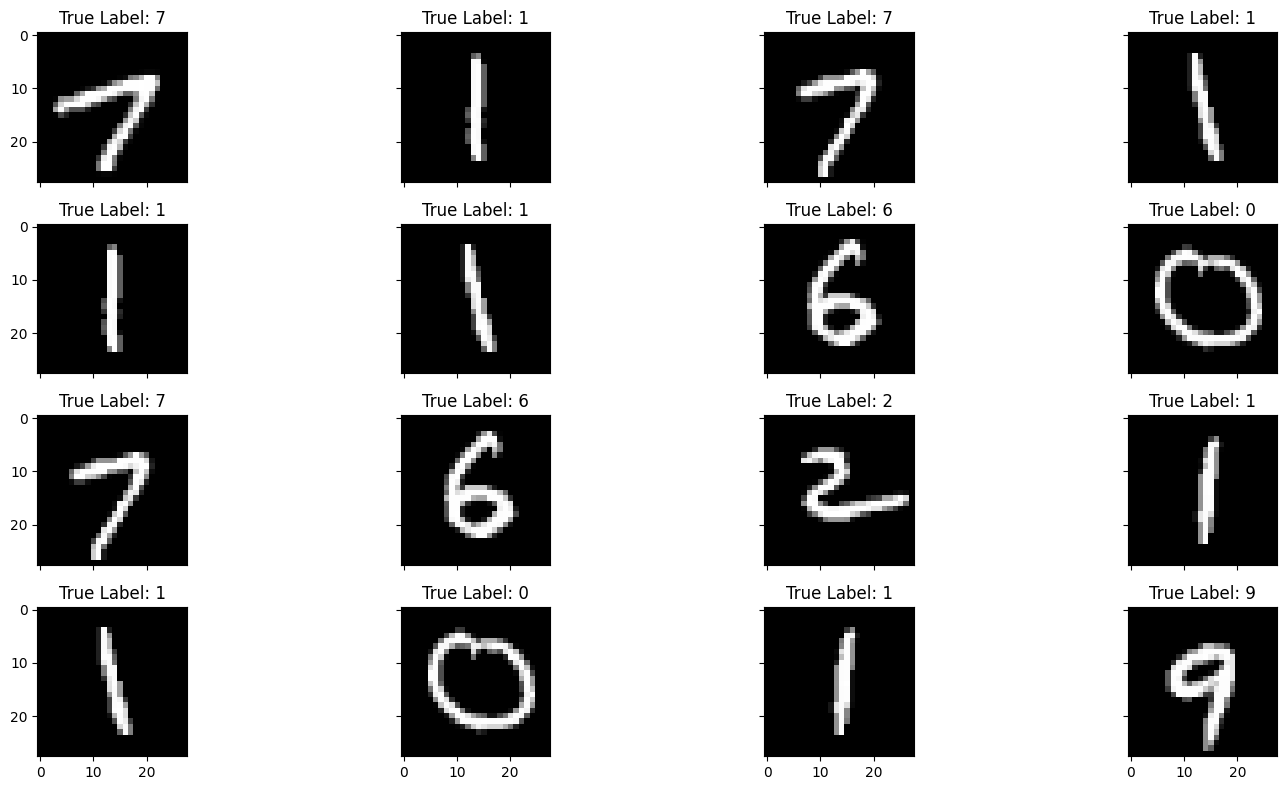

In [ ]:
fig,ax= plt.subplots(nrows=4,ncols=4,figsize=(16,8),sharex=True,sharey=True)
for i in range(4):
  for j in range(4):
    k=(i+1)*(j+1)+100
    ax[i,j].imshow(training_data.data[k],cmap='gray')
    ax[i,j].set_title(f'True Label: {training_data.targets[k]}')
plt.tight_layout()


### Distribution of Training Data into different classes. We can see data is uniformly distributed

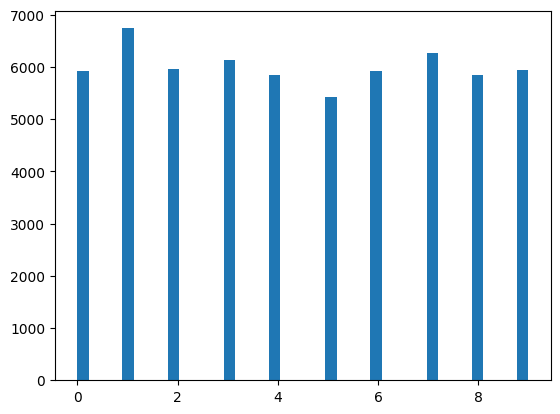

In [ ]:
plt.hist(train_iterator.dataset.dataset.targets,bins=40)
plt.show()

# Changing the dimensions of data in order to use it for training.

In [ ]:
# Creates one hot vectors out of given targets
def one_hot(Y):
    one_hot_Y = torch.zeros(len(Y), 10)
    one_hot_Y[range(len(Y)), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y   # 10X64

In [ ]:
# Flattening the images for training the model
X_train=[]
Y_train=[]
for X, Y in train_iterator:
    X=torch.flatten(X,start_dim=1)
    Y=one_hot(Y) # 10X 64
    X_train.append(X)
    Y_train.append(Y)

In [ ]:
X_train[0].shape

torch.Size([64, 784])

In [ ]:
Y_train[0].shape

torch.Size([10, 64])

In [ ]:
X_valid = [torch.flatten(x[0],start_dim=1) for x in valid_iterator]
Y_valid = [y[1] for y in valid_iterator]

In [ ]:
X_valid[0].shape

torch.Size([6000, 784])

In [ ]:
X_test = [torch.flatten(x[0],start_dim=1) for x in test_iterator]
Y_test = [y[1] for y in test_iterator]

In [ ]:
print(X_test[0].shape,Y_test[0].shape)

torch.Size([10000, 784]) torch.Size([10000])


## Loss Function:

In [ ]:
def Cross_entropy(Y, pred,lambda1=0,params_sum=0):
    J = Y * pred
    J=torch.sum(J,0)
    return -torch.sum(torch.log(J))+ lambda1*params_sum

### Activation Functions

Relu Activation Function: $$ReLU(x) = max(0,x)$$

In [ ]:
def ReLU(x):
  return torch.maximum(torch.zeros_like(x),x)

def ReLU_deriv(Z):
    return Z > 0

Sigmoid Activationn Function: $$\sigma(x)=\frac{1}{1+e^{-x}}$$

In [ ]:
def Sigmoid(x):
  return 1/(1+torch.exp(-x))

In [ ]:
def Grad_Sigmoid(x):
  return Sigmoid(x)*(1-Sigmoid(x))

Tanh Activation Function: $$tanh(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}$$

In [ ]:
def Tanh(x):
  return torch.div((torch.exp(x)-torch.exp(-x)),(torch.exp(x)+torch.exp(-x)))

In [ ]:
def Grad_Tanh(x):
  return 1-Tanh(x)*Tanh(x)

Softmax Function: $$Softmax(X_{n*1}) = \Bigg(\frac{e^{x_i}}{\sum_{j}e^{j}}\Bigg)_{n*1}$$

In [ ]:
def Softmax(X,dim=0):
  Y=torch.zeros_like(X)
  if dim==0:
    i=0
    for x in X.T:
      Y.T[i]=torch.exp(x)/sum(torch.exp(x))
      i+=1
  else:
    i=0
    for x in X:
      Y[i]=torch.exp(x)/sum(torch.exp(x))
      i+=1
  return Y


# The  Model

## Defining The Architecture

In [ ]:
torch.seed()
def init_params(In = [784,500,250,100],Out = [500,250,100,10]):
    param=[]
    for I,O in zip(In,Out):
      M=np.sqrt(6/(I+O))
      W=torch.FloatTensor(O, I).uniform_(-M,M)
      b=torch.FloatTensor(O,1).uniform_(-M,M)
      param.append(W)
      param.append(b)
    return param

In [ ]:
params=init_params()
for a in params:
  print(a.shape)

torch.Size([500, 784])
torch.Size([500, 1])
torch.Size([250, 500])
torch.Size([250, 1])
torch.Size([100, 250])
torch.Size([100, 1])
torch.Size([10, 100])
torch.Size([10, 1])


### Forward Propagation

In [ ]:
def forward_prop(param, X,Activation=Sigmoid,OutAct=Softmax): #hiddenacti,outacti
    #print('X',X)
    Z1=torch.mm(param[0],X.T)+param[1]
    #print('Z1',Z1)
    Activations=[X.T, Z1,Activation(Z1)]
    #print('A1',Activations[-1])
    for i in range(2,len(param),2):
      Z = torch.mm(param[i],Activations[-1])+param[i+1]
      Activations.append(Z)
      #print('Z',Z)
      if i!=len(param)-2:
        Activations.append(Activation(Z))
       # print("A",torch.nn.functional.sigmoid(Z))
      else:
        Activations.append(OutAct(Z,dim=0))
        #print("A",torch.nn.functional.softmax(Z,dim=0))
    return Activations

In [ ]:
Activ=forward_prop(params,X_train[0])

In [ ]:
for a in Activ:
  print(a.shape)

torch.Size([784, 64])
torch.Size([500, 64])
torch.Size([500, 64])
torch.Size([250, 64])
torch.Size([250, 64])
torch.Size([100, 64])
torch.Size([100, 64])
torch.Size([10, 64])
torch.Size([10, 64])


In [ ]:
Activ[-1].T[0]  # Looking into output from softmax

tensor([0.0832, 0.0293, 0.1133, 0.1879, 0.1275, 0.1134, 0.0691, 0.0290, 0.1510,
        0.0964])

### Back Ward Propagation

In [ ]:
def backward_pass(X, Y, activations, parameters, grad_act = Grad_Sigmoid):
    grads = {}
    m = X.shape[1]
    dZ = activations[-1] - Y  #10X64
    dZ=dZ/m
    #print(dZ.shape)
    #print(activations[-3].shape)
    grads[f'db{len(parameters) // 2}'] = torch.sum(dZ, dim=1, keepdim=True)
    grads[f'dW{len(parameters) // 2}'] = torch.mm(dZ, activations[-3].T)

    for i in reversed(range(1, len(parameters) // 2)):
        dZ = torch.mm(parameters[2*i].T, dZ) *(grad_act(activations[2*i]))

        grads[f'db{i}'] = torch.sum(dZ, dim=1, keepdim=True)
        grads[f'dW{i}'] = torch.mm(dZ, activations[2*i-2].T)
    return grads


In [ ]:
grad=backward_pass(X_train[0],Y_train[0],Activ,params)

In [ ]:
for a in reversed(grad):
  print(a)
  print(grad[a].shape)

dW1
torch.Size([500, 784])
db1
torch.Size([500, 1])
dW2
torch.Size([250, 500])
db2
torch.Size([250, 1])
dW3
torch.Size([100, 250])
db3
torch.Size([100, 1])
dW4
torch.Size([10, 100])
db4
torch.Size([10, 1])


### Updation of Parameters


In [ ]:
def update_params(param,gradp, alpha, lambda1=0):
    r=0
    for i ,j in zip(param,reversed(gradp)):
      #print(i.shape,gradp[j].shape)
      if r%2+1:
        param[r]=(1-lambda1*alpha)*i-alpha*gradp[j]
      else:
        param[r]=i-alpha*gradp[j]
      r+=1
    return param

In [ ]:
uparam=update_params(params,grad,0.01)

### Predictions and Accuracy functions

In [ ]:
def get_predictions(A4):
    return torch.argmax(A4, 0)

def get_accuracy(predictions, Y):
    #print(predictions, Y)
    X=torch.argmax(Y,0)
    #print(X.shape)
    #print(predictions.shape)
    return torch.sum(predictions == X) / len(X)

## Gradient Descent Algorithm

In [ ]:
def gradient_descent(X_train,Y_train, X_test, Y_test , X_valid, Y_valid, Activation=Sigmoid,
                     grad_act=Grad_Sigmoid, OutAct = Softmax,  alpha=0.01, epoch= 20,lambda1=0):
    params = init_params()
    #print('weight_Initialised.....')
    EpochLoss_train=[]
    EpochLoss_valid=[]
    for epo in range(epoch):

      for X,Y in zip(X_train,Y_train):

        activations = forward_prop(params,X, Activation, OutAct)

        gradp = backward_pass(X,Y, activations, params,grad_act)

        params = update_params(params, gradp, alpha,lambda1)

        #predictions = get_predictions(activations[-1])
      param_sum = sum([torch.sum(params[i]) for i in range(0,8,2)])
      #EpochLoss_train.append(Cross_entropy(Y,activations[-1],lambda1,params_sum=param_sum))

      Activ1=forward_prop(params, X_valid[0], Activation, OutAct)

      EpochLoss_valid.append(Cross_entropy(one_hot(Y_valid[0]),Activ1[-1])/6000)
      train_true=0
      loss=0
      for X,Y in zip(X_train,Y_train):

        activt=forward_prop(params, X, Activation, OutAct)
        Y_hat_train = get_predictions(activt[-1])
        loss += Cross_entropy(Y,activt[-1],lambda1,params_sum=param_sum)
        train_true += torch.sum(Y_hat_train==torch.argmax(Y,0))

      EpochLoss_train.append(loss/54000)
  #activations = forward_prop(params, X)
      Y_hat_val=get_predictions(Activ1[-1])
      #Y_hat_train = get_predictions(activations[-1])
      print(f'**************************** Epoch {epo+1} ***********************************')
      print('Training Accuracy: ',(train_true/54000).item()*100)
      print('Validation Accuracy: ',(torch.sum(Y_hat_val==Y_valid[0])/6000).item()*100)
      print('------------------------------------------------------------------------')
    Activ2=forward_prop(params, X_test[0], Activation, OutAct)
    Y_hat_test = get_predictions(Activ2[-1])
    print('Test Accuracy: ',(torch.sum(Y_hat_test==Y_test[0])/10000).item()*100)
    return params,EpochLoss_train,EpochLoss_valid , Y_hat_test

## Confusion Matrix

In [ ]:
def Confusion_Matrix(Y_pre, Y):
    number_of_classes = 10
    conf_matrix = np.zeros((number_of_classes, number_of_classes),dtype=int)
    for true_label, prediction in zip(Y_pre ,Y):
      conf_matrix[true_label, prediction] += 1
    return conf_matrix

In [ ]:
def plot_confusion_matrix(confusion_matrix):
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    num_classes = confusion_matrix.shape[0]

    plt.xticks(np.arange(num_classes), range(num_classes))
    plt.yticks(np.arange(num_classes), range(num_classes))

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add text annotations for each cell
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, str(confusion_matrix[i, j]), horizontalalignment="center", color="black")

    plt.show()



## (1)  Using Sigmoid and softmax
Here I am using sigmoid activation in hidden layers and softmax at the output layer doing gradient descent with learning rate 1 and runs for 15 epoch


In [ ]:
# For differen learning rate please change alpha
Params = gradient_descent(X_train,Y_train, X_test, Y_test , X_valid, Y_valid, Activation=Sigmoid,
                     grad_act=Grad_Sigmoid, OutAct = Softmax,  alpha=1, epoch= 15)

**************************** Epoch 1 ***********************************
Training Accuracy:  41.93703830242157
Validation Accuracy:  41.11666679382324
------------------------------------------------------------------------
**************************** Epoch 2 ***********************************
Training Accuracy:  78.2537043094635
Validation Accuracy:  78.29999923706055
------------------------------------------------------------------------
**************************** Epoch 3 ***********************************
Training Accuracy:  84.62036848068237
Validation Accuracy:  84.26666855812073
------------------------------------------------------------------------
**************************** Epoch 4 ***********************************
Training Accuracy:  87.37407326698303
Validation Accuracy:  87.23333477973938
------------------------------------------------------------------------
**************************** Epoch 5 ***********************************
Training Accuracy:  88.807410001

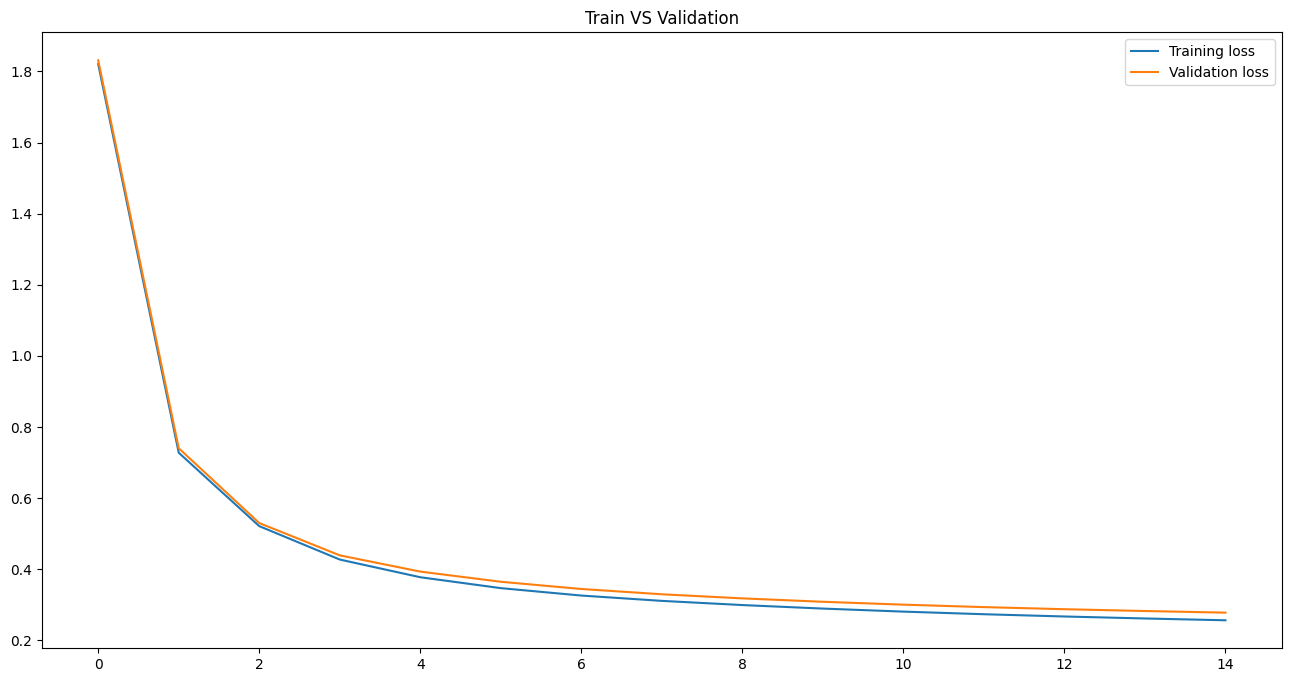

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(Params[1],label='Training loss')
plt.plot(Params[2],label='Validation loss')
plt.title('Train VS Validation')
plt.legend()
plt.show()

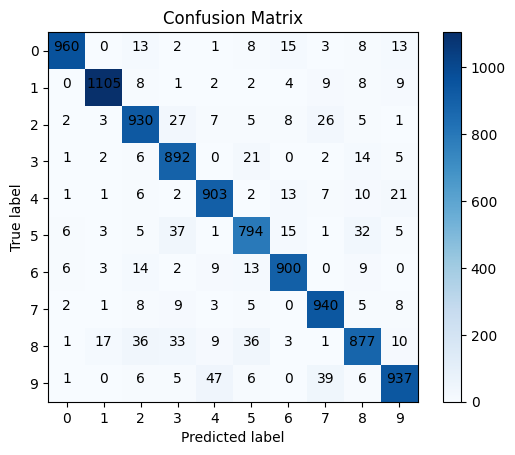

In [ ]:
Mat = Confusion_Matrix(Params[-1],Y_test[0])
plot_confusion_matrix(Mat)

## (1)  **Using ReLU and softmax**
Here I am using ReLu activation in hidden layers and softmax at the output layer doing gradient descent with learning rate 0.1 and runs for 15 epoch

In [ ]:
Params = gradient_descent(X_train,Y_train, X_test, Y_test , X_valid, Y_valid, Activation=ReLU,
                     grad_act=ReLU_deriv, OutAct = Softmax,  alpha=1, epoch= 15)

**************************** Epoch 1 ***********************************
Training Accuracy:  95.2129602432251
Validation Accuracy:  94.81666684150696
------------------------------------------------------------------------
**************************** Epoch 2 ***********************************
Training Accuracy:  97.25925922393799
Validation Accuracy:  96.66666388511658
------------------------------------------------------------------------
**************************** Epoch 3 ***********************************
Training Accuracy:  98.14444184303284
Validation Accuracy:  97.2166657447815
------------------------------------------------------------------------
**************************** Epoch 4 ***********************************
Training Accuracy:  98.56851696968079
Validation Accuracy:  97.46666550636292
------------------------------------------------------------------------
**************************** Epoch 5 ***********************************
Training Accuracy:  98.7851858139

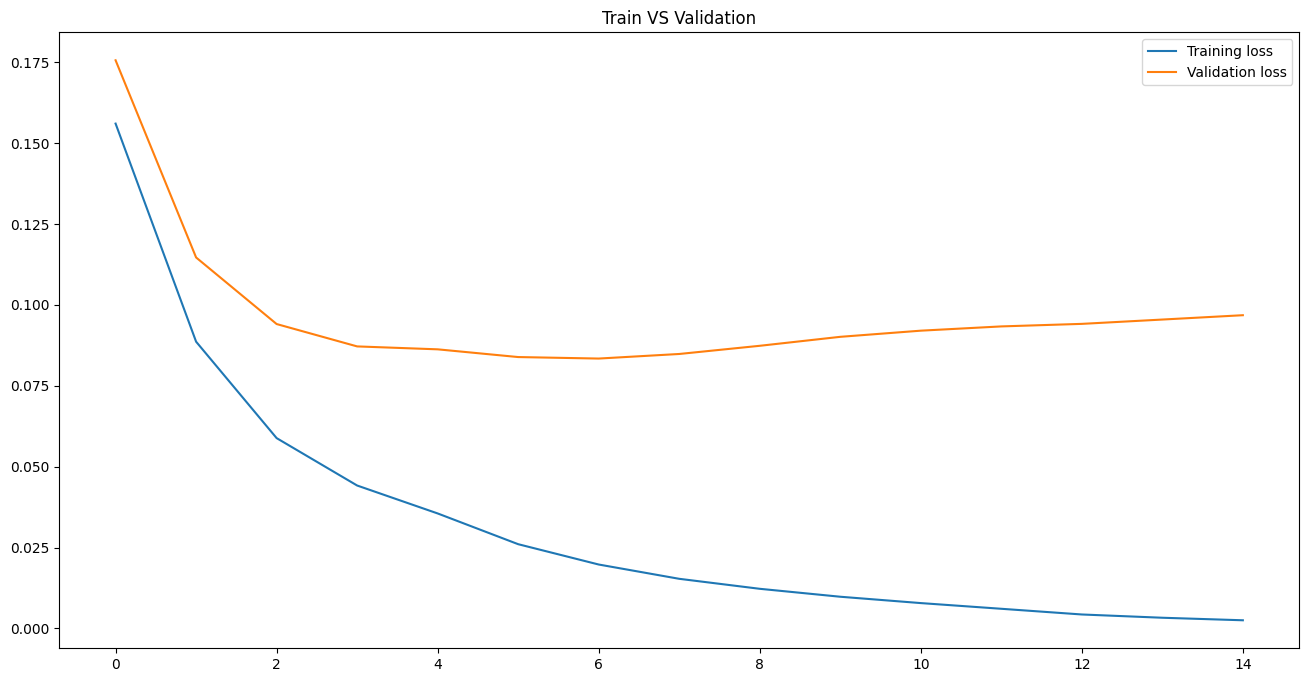

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(Params[1],label='Training loss')
plt.plot(Params[2],label='Validation loss')
plt.title('Train VS Validation')
plt.legend()
plt.show()

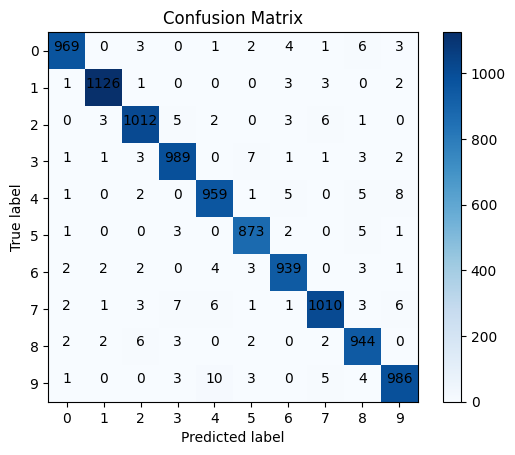

In [ ]:
Mat = Confusion_Matrix(Params[-1],Y_test[0])
plot_confusion_matrix(Mat)

## (1)  **Using Tanh and softmax**
Here I am using Tanh activation in hidden layers and softmax at the output layer doing gradient descent with learning rate 0.1 and runs for 15 epoch

In [ ]:
Params = gradient_descent(X_train,Y_train, X_test, Y_test , X_valid, Y_valid, Activation=Tanh,
                     grad_act=Grad_Tanh, OutAct = Softmax,  alpha=0.1, epoch= 15)

**************************** Epoch 1 ***********************************
Training Accuracy:  89.08148407936096
Validation Accuracy:  88.84999752044678
------------------------------------------------------------------------
**************************** Epoch 2 ***********************************
Training Accuracy:  90.65740704536438
Validation Accuracy:  90.6499981880188
------------------------------------------------------------------------
**************************** Epoch 3 ***********************************
Training Accuracy:  91.55185222625732
Validation Accuracy:  91.50000214576721
------------------------------------------------------------------------
**************************** Epoch 4 ***********************************
Training Accuracy:  92.08518266677856
Validation Accuracy:  91.81666374206543
------------------------------------------------------------------------
**************************** Epoch 5 ***********************************
Training Accuracy:  92.575925588

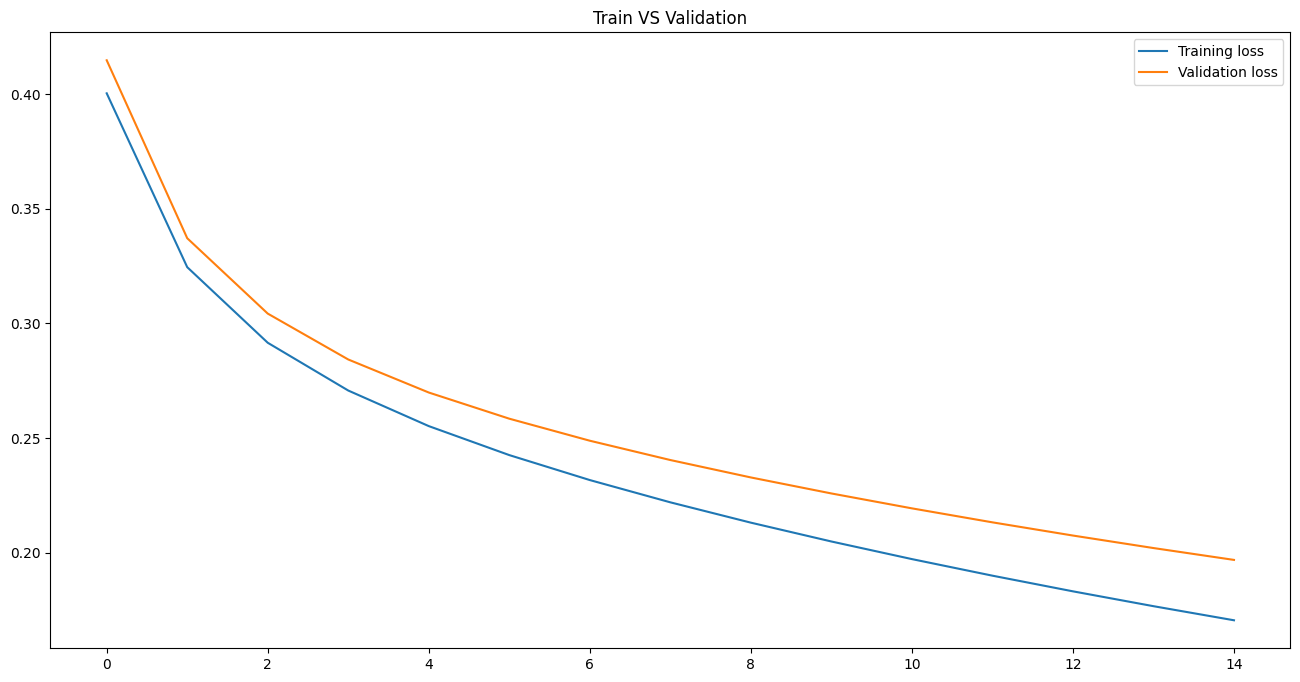

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(Params[1],label='Training loss')
plt.plot(Params[2],label='Validation loss')
plt.title('Train VS Validation')
plt.legend()
plt.show()

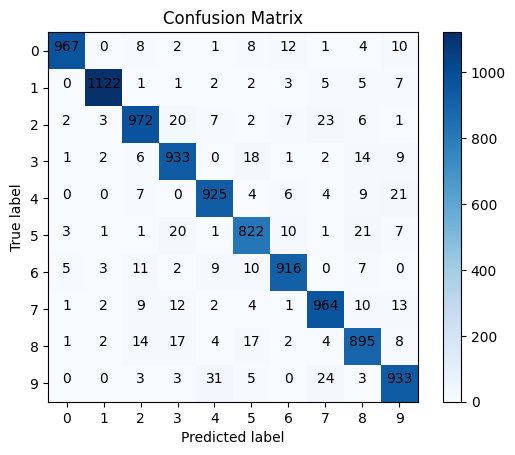

In [ ]:
Mat = Confusion_Matrix(Params[-1],Y_test[0])
plot_confusion_matrix(Mat)

# **With Regularisation**

### Sigmoid

In [ ]:
Params = gradient_descent(X_train,Y_train, X_test, Y_test , X_valid, Y_valid, Activation=Sigmoid,
                     grad_act=Grad_Sigmoid, OutAct = Softmax,  alpha=0.1, epoch= 15,lambda1=0.01)

**************************** Epoch 1 ***********************************
Training Accuracy:  11.299999803304672
Validation Accuracy:  10.649999976158142
------------------------------------------------------------------------
**************************** Epoch 2 ***********************************
Training Accuracy:  11.299999803304672
Validation Accuracy:  10.649999976158142
------------------------------------------------------------------------
**************************** Epoch 3 ***********************************
Training Accuracy:  11.299999803304672
Validation Accuracy:  10.649999976158142
------------------------------------------------------------------------
**************************** Epoch 4 ***********************************
Training Accuracy:  11.299999803304672
Validation Accuracy:  10.649999976158142
------------------------------------------------------------------------
**************************** Epoch 5 ***********************************
Training Accuracy:  11.

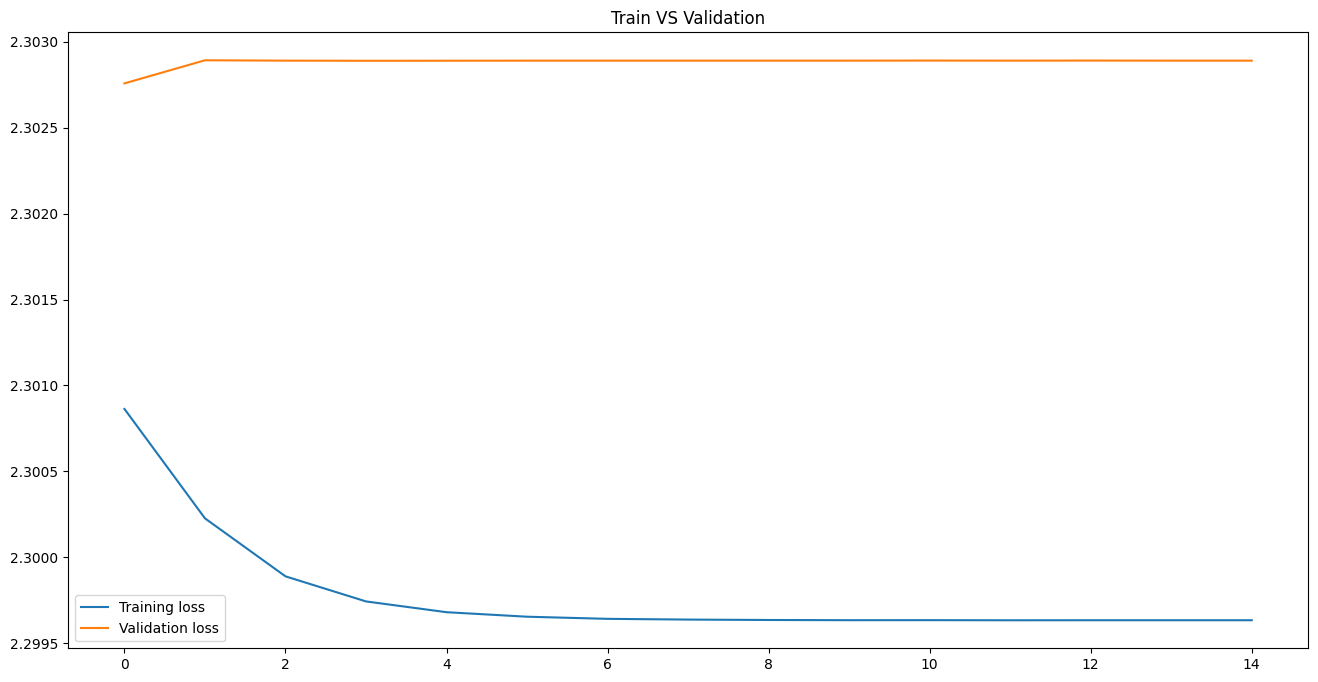

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(Params[1],label='Training loss')
plt.plot(Params[2],label='Validation loss')
plt.title('Train VS Validation')
plt.legend()
plt.show()

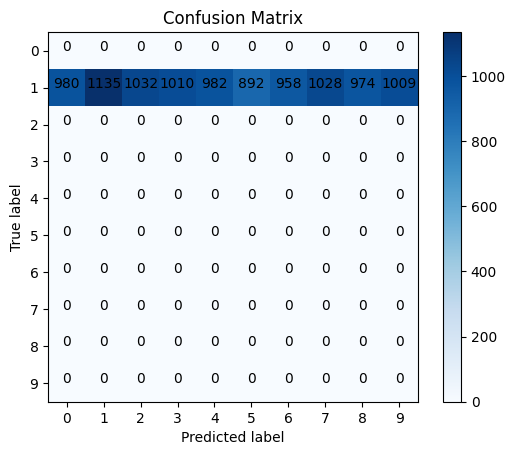

In [ ]:
Mat = Confusion_Matrix(Params[-1],Y_test[0])
plot_confusion_matrix(Mat)

### ReLU

In [ ]:
Params = gradient_descent(X_train,Y_train, X_test, Y_test , X_valid, Y_valid, Activation=ReLU,
                     grad_act=ReLU_deriv, OutAct = Softmax,  alpha=0.1, epoch= 15,lambda1=0.01)

**************************** Epoch 1 ***********************************
Training Accuracy:  73.83888959884644
Validation Accuracy:  72.89999723434448
------------------------------------------------------------------------
**************************** Epoch 2 ***********************************
Training Accuracy:  71.65370583534241
Validation Accuracy:  71.48333191871643
------------------------------------------------------------------------
**************************** Epoch 3 ***********************************
Training Accuracy:  70.78889012336731
Validation Accuracy:  70.59999704360962
------------------------------------------------------------------------
**************************** Epoch 4 ***********************************
Training Accuracy:  71.11851572990417
Validation Accuracy:  70.86666822433472
------------------------------------------------------------------------
**************************** Epoch 5 ***********************************
Training Accuracy:  71.59073948

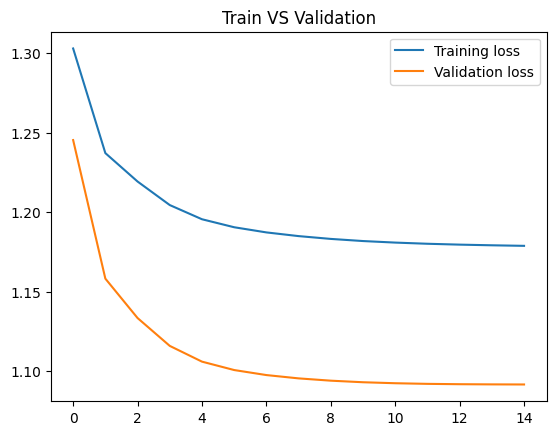

In [ ]:
plt.plot(figsize=(16,8))
plt.plot(Params[1],label='Training loss')
plt.plot(Params[2],label='Validation loss')
plt.title('Train VS Validation')
plt.legend()
plt.show()

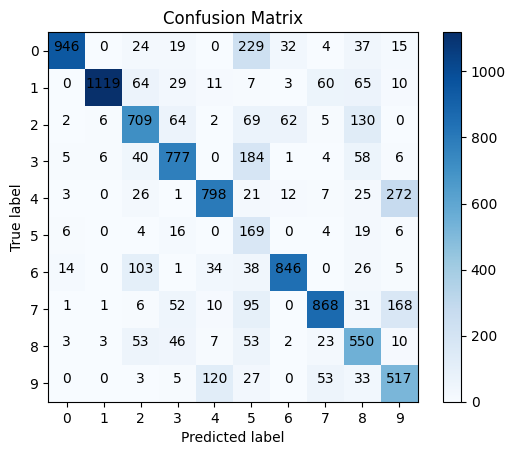

In [ ]:
Mat = Confusion_Matrix(Params[-1],Y_test[0])
plot_confusion_matrix(Mat)

### Tanh

In [ ]:
Params = gradient_descent(X_train,Y_train, X_test, Y_test , X_valid, Y_valid, Activation=Tanh,
                     grad_act=Grad_Tanh, OutAct = Softmax,  alpha=0.1, epoch= 15,lambda1=0.01)

**************************** Epoch 1 ***********************************
Training Accuracy:  81.77777528762817
Validation Accuracy:  81.30000233650208
------------------------------------------------------------------------
**************************** Epoch 2 ***********************************
Training Accuracy:  75.61296224594116
Validation Accuracy:  75.3000020980835
------------------------------------------------------------------------
**************************** Epoch 3 ***********************************
Training Accuracy:  72.20370173454285
Validation Accuracy:  72.28333353996277
------------------------------------------------------------------------
**************************** Epoch 4 ***********************************
Training Accuracy:  70.30740976333618
Validation Accuracy:  70.20000219345093
------------------------------------------------------------------------
**************************** Epoch 5 ***********************************
Training Accuracy:  67.442589998

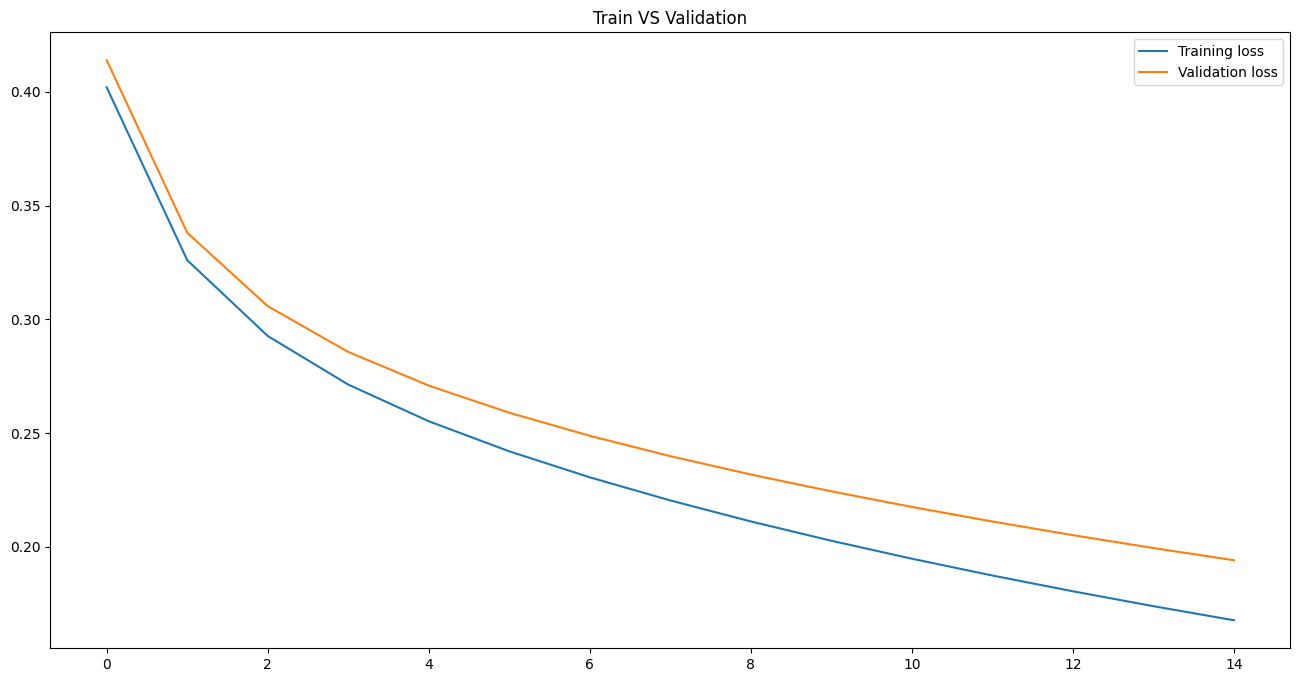

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(Params[1],label='Training loss')
plt.plot(Params[2],label='Validation loss')
plt.title('Train VS Validation')
plt.legend()
plt.show()

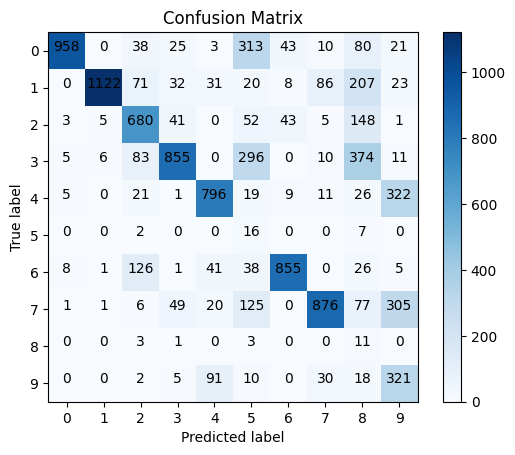

In [ ]:
Mat = Confusion_Matrix(Params[-1],Y_test[0])
plot_confusion_matrix(Mat)

# **Using Pytorch**

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = torch.nn.Linear(input_dim, 500)
        self.hidden1_fc = torch.nn.Linear(500, 250)
        self.hidden2_fc = torch.nn.Linear(250, 100)
        self.output_fc = torch.nn.Linear(100,output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        h_1 = torch.nn.functional.relu(self.input_fc(x))
        h_2 = torch.nn.functional.relu(self.hidden1_fc(h_1))
        h_3 = torch.nn.functional.relu(self.hidden2_fc(h_2))
        y_pred = self.output_fc(h_3)
        return y_pred, h_3

In [ ]:
model = MLP(784,10)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for data in iterator:
        x=torch.flatten(data[0],start_dim=1)
        y=data[1]
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for data in iterator:
            x=torch.flatten(data[0],start_dim=1)
            y=data[1]
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
# To Save the Model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')




    print(f'Epoch: {epoch+1:02} ')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 
	Train Loss: 0.275 | Train Acc: 91.88%
	 Val. Loss: 0.145 |  Val. Acc: 95.88%
Epoch: 02 
	Train Loss: 0.101 | Train Acc: 96.89%
	 Val. Loss: 0.104 |  Val. Acc: 96.97%
Epoch: 03 
	Train Loss: 0.065 | Train Acc: 97.93%
	 Val. Loss: 0.095 |  Val. Acc: 97.30%
Epoch: 04 
	Train Loss: 0.049 | Train Acc: 98.55%
	 Val. Loss: 0.095 |  Val. Acc: 97.40%
Epoch: 05 
	Train Loss: 0.038 | Train Acc: 98.80%
	 Val. Loss: 0.105 |  Val. Acc: 97.58%
Epoch: 06 
	Train Loss: 0.032 | Train Acc: 98.95%
	 Val. Loss: 0.103 |  Val. Acc: 97.28%
Epoch: 07 
	Train Loss: 0.026 | Train Acc: 99.21%
	 Val. Loss: 0.110 |  Val. Acc: 97.37%
Epoch: 08 
	Train Loss: 0.024 | Train Acc: 99.24%
	 Val. Loss: 0.092 |  Val. Acc: 97.90%
Epoch: 09 
	Train Loss: 0.021 | Train Acc: 99.31%
	 Val. Loss: 0.092 |  Val. Acc: 97.98%
Epoch: 10 
	Train Loss: 0.018 | Train Acc: 99.42%
	 Val. Loss: 0.112 |  Val. Acc: 97.58%


In [ ]:
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

In [ ]:
print('Test Loss: ',test_loss)
print('Test Accuracy: ',test_acc)

Test Loss:  0.10441038757562637
Test Accuracy:  0.9795999526977539


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for data in iterator:
            x=torch.flatten(data[0],start_dim=1)
            y=data[1]
            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = torch.nn.functional.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
from sklearn import metrics

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

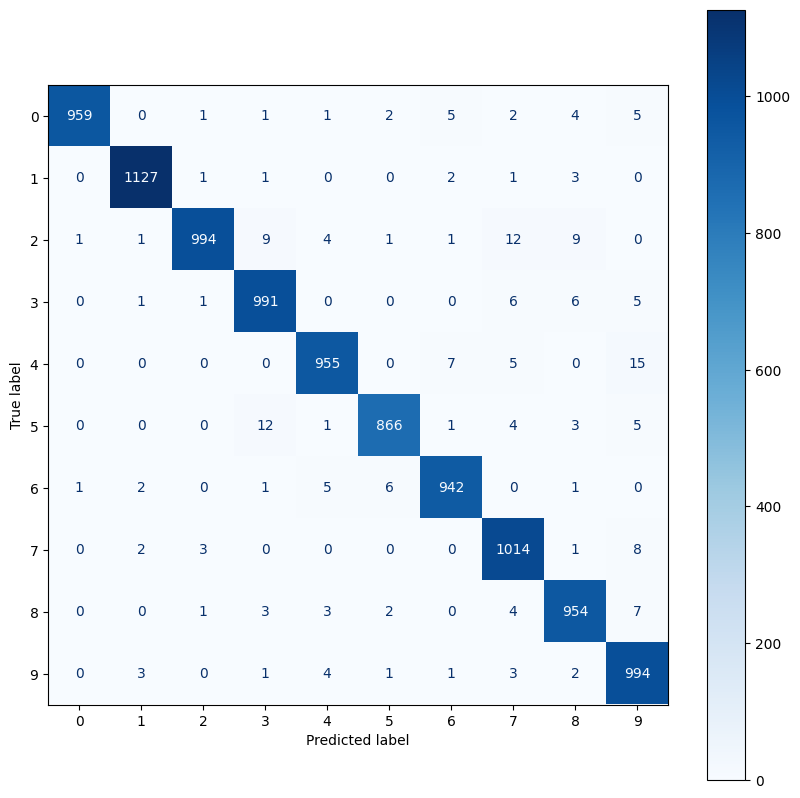

In [ ]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

## In Reality Model had done a good  job as we can see the following:

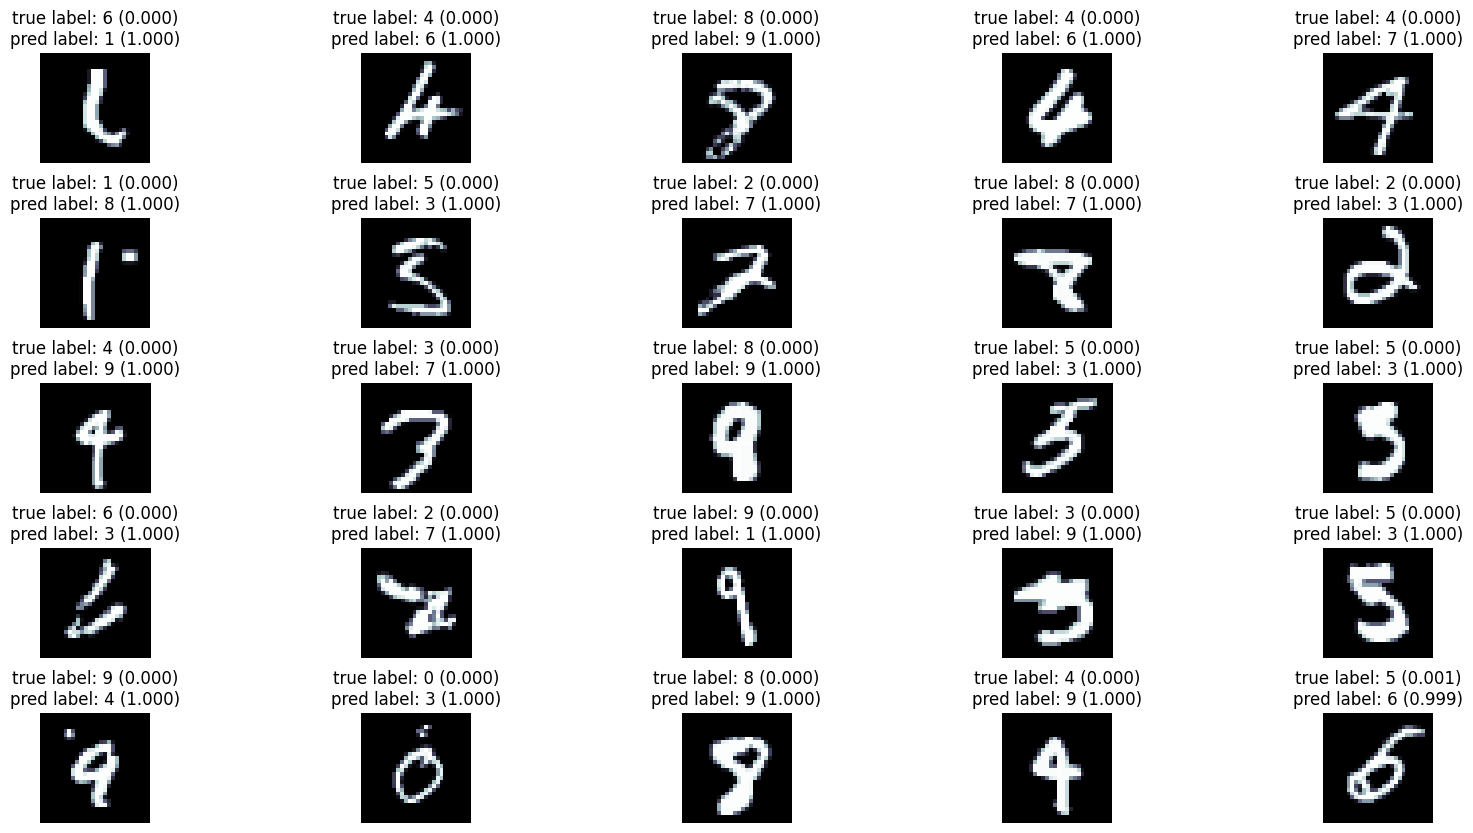

In [ ]:

N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

# **Summary**


1. **Sigmoid**  With $Epoch=15$<br>
Here are the Details: <br>
     > * $Learning \ rate = 0.01$
      *   Train Accuracy : $67.13\%$
      *   Validation Accuracy: $66.39 \%$
      *   Test Accuracy: $67.45\%$
      * Time: $4m10sec$<br>
    > *$Learning \ rate = 0.01$
      *   Train Accuracy : Not Learning
      *   Validation Accuracy: ----
      *   Test Accuracy: ----
      *   Time: ---<br>
    > *$Learning \ rate = 1$
      *   Train Accuracy : $92.17\%$
      *   Validation Accuracy: $91.85 \%$
      *   Test Accuracy: $92.14\%$
      * Time: $4m10sec$

---




2. **ReLU**  With $Epoch=15$<br>
Here are the Details: <br>
     > * $Learning \ rate = 0.01$
      *   Train Accuracy : $90.47\%$
      *   Validation Accuracy: $90.20 \%$
      *   Test Accuracy: $91.00\%$
      * Time: $4m1sec$<br>
    > *$Learning \ rate = 0.1$
      *   Train Accuracy : $97.33$\%
      *   Validation Accuracy: $96.1$%
      *   Test Accuracy:$96.64$%
      *   Time: 3m55s<br>
    > *$Learning \ rate = 1$
      *   Train Accuracy : $99.83%$
      *   Validation Accuracy: $97.75%$
      *   Test Accuracy: $98.07%$
      * Time: $3m0sec$

---
3. **Tanh**  With $Epoch=15$<br>
Here are the Details: <br>
     > * $Learning \ rate = 0.01$
      *   Train Accuracy : $89.97%$
      *   Validation Accuracy: $90.41\%$
      *   Test Accuracy: $90.74\%$
      * Time: $4m5s$<br>
    > *$Learning \ rate = 0.1$
      *   Train Accuracy : $95.02$
      *   Validation Accuracy: $94.38%$
      *   Test Accuracy: $94.48%$
      *   Time: 3m10s<br>
    > *$Learning \ rate = 1$
      *   Train Accuracy : $99.25%$
      *   Validation Accuracy: $97.69%$
      *   Test Accuracy: $97.58%$
      * Time: $4m6sec$

---




#Regularisation penality=0.01
1. **ReLU**  With $Epoch=15$ <br>
Here are the Details: <br>
     > * $Learning \ rate = 0.01$
      *   Train Accuracy :-----
      *   Validation Accuracy: ----
      *   Test Accuracy: -----
      * Time: $4m10sec$<br>
2. **Tanh**
    > *$Learning \ rate = 0.01$
      *   Train Accuracy : $65.04%$
      *   Validation Accuracy: $63.07%$
      *   Test Accuracy: $64.70%$
      *   Time: ---<br>
---


1. **Pytorch**  With $Epoch=10$ and Adam optimizer<br>
Here are the Details: <br>
     > * $Learning \ rate = 0.01$
      *   Train Accuracy : $97.95%$
      *   Validation Accuracy: $95.07%$
      *   Test Accuracy: $95.20%$
      * Time: $3m45s$<br>
    > *$Learning \ rate = 0.01$
      *   Train Accuracy : Not doing good job
      *   Validation Accuracy: ----
      *   Test Accuracy: ----
      *   Time: ---<br>
    > *$Learning \ rate = 0.001$
      *   Train Accuracy : $99.48%$
      *   Validation Accuracy: $97.85%$
      *   Test Accuracy: $97.75%$
      * Time: $2m55sec$

---
